# **Basic GNN Model Hyperparameter Optimization**

This notebook search for the best hyperparameters by implementing a Cross-Validation Setup. The Hyperparameters that will be searched are the Learning Rate, the Weight Decay and the Embedding Size of the Graph Neural Network.
An Early Stopping Mechanism will help terminate trials that are not improving.

The data from the UPFD Framework has been already split in Training, Validation and Test Set and is downloadable by using simple commands inside the Pytorch Geometric environment.

## Download and import Libraries for the Environment 


---



Download the right libraries depending if we are using a CPU or a GPU.

In [1]:
# If this notebook is executed on colab, uncomment this
#if torch.cuda.is_available():
  #!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu102.html
#else:
  #!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html

#!pip install optuna

In [9]:
import torch
import optuna
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.nn import Linear, LogSoftmax
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, global_max_pool

from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, optimize_GNN, train_step, val_step, train_all_optuna


In [3]:
# Set GPU as Device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f"Training Device: {device}")

Training Device: cpu


### Import data

In [4]:
datasets = pk.load(open('./data/datasets.pkl', 'rb'))

# Training Functions

In [5]:
class GNN(torch.nn.Module):

    def __init__(self, num_n_feature, num_g_feature, emb_size):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size

        self.in_layer = GCNConv(num_n_feature, emb_size)
        self.conv1 = GCNConv(emb_size, emb_size)
       
       # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)
    
    def forward(self, x, edges_idx, batch_idx, g_features):

        x = self.in_layer(x, edges_idx)

        x = self.conv1(x, edges_idx)

        flatten = torch.cat([global_mean_pool(x, batch_idx),
                             global_max_pool(x, batch_idx)], axis=1)
        
        if g_features.size()[-1]>1:
            g_ft = self.lin_g(g_features)
            flatten = torch.cat([flatten, g_ft], axis=1)

        out = self.act(self.out_layer(flatten))

        return out

# **Training**

Training Function that will be executed every time a trial is done. In this function the hyperparameters are chosen based on suggestions from the hyperparameter optimizer chosen with Optuna.


In [6]:
epochs = 60  

models = train_all_optuna(GNN,datasets,epochs = epochs)

[I 2022-01-02 20:18:14,153] A new study created in memory with name: no-name-bab08736-3302-4a10-b29e-7b737395d83f


--> Train on: origin


[I 2022-01-02 20:20:26,571] Trial 0 finished with value: 0.9110179227941176 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 140}. Best is trial 0 with value: 0.9110179227941176.
[I 2022-01-02 20:22:13,257] Trial 1 finished with value: 0.8393382352941176 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.9110179227941176.
[I 2022-01-02 20:23:14,064] Trial 2 finished with value: 0.8377757352941175 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 100}. Best is trial 0 with value: 0.9110179227941176.
[I 2022-01-02 20:23:53,923] Trial 3 finished with value: 0.8898590686274509 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 256, 'embedding_space_dim': 60}. Best is trial 0 with value: 0.9110179227941176.
[I 2022-01-02 20:25:12,000] Trial 4 finished with value: 0.8

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.4043081800142924  loss_val=0.4485500156879425 | acc_train=0.8275505514705882  acc_val=0.7944623161764706
Epochs: 20 | loss_train=0.32733895381291706  loss_val=0.2967892587184906 | acc_train=0.8644301470588235  acc_val=0.8414522058823529
Epochs: 30 | loss_train=0.3100877304871877  loss_val=0.2968661040067673 | acc_train=0.8620940563725491  acc_val=0.9022288602941176
Epochs: 40 | loss_train=0.3306972185770671  loss_val=0.2583143413066864 | acc_train=0.8594898897058824  acc_val=0.8914292279411764
Epochs: 50 | loss_train=0.2767372528711955  loss_val=0.3713296353816986 | acc_train=0.8947227328431372  acc_val=0.8413947610294117
Epochs: 60 | loss_train=0.3004448016484578  loss_val=0.2941800504922867 | acc_train=0.8688725490196078  acc_val=0.9110179227941176


[I 2022-01-02 20:29:49,615] A new study created in memory with name: no-name-c4bc6490-7178-4a10-a8cb-fc7dd2e9ef93


--> Train on: dataset1


[I 2022-01-02 20:30:48,920] Trial 0 finished with value: 0.8307674632352942 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 60}. Best is trial 0 with value: 0.8307674632352942.
[I 2022-01-02 20:32:08,368] Trial 1 finished with value: 0.7474149816176471 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.01, 'batch_size': 512, 'embedding_space_dim': 80}. Best is trial 0 with value: 0.8307674632352942.
[I 2022-01-02 20:33:25,530] Trial 2 finished with value: 0.8084558823529411 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 120}. Best is trial 0 with value: 0.8307674632352942.
[I 2022-01-02 20:34:46,524] Trial 3 finished with value: 0.8233762254901961 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 120}. Best is trial 0 with value: 0.8307674632352942.
[I 2022-01-02 20:35:44,992] Trial 4 finished with value: 0.66

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.5571814941035377  loss_val=0.993895947933197 | acc_train=0.7714971405228758  acc_val=0.5183823529411764
Epochs: 20 | loss_train=0.6675878630744086  loss_val=0.4328757345676422 | acc_train=0.7810968137254902  acc_val=0.8287683823529411
Epochs: 30 | loss_train=0.43286598722139996  loss_val=0.4618731915950775 | acc_train=0.8157679738562091  acc_val=0.8420955882352942
Epochs: 40 | loss_train=0.38239395287301803  loss_val=0.41174432039260866 | acc_train=0.8480392156862746  acc_val=0.8291360294117647
Epochs: 50 | loss_train=0.4700489905145433  loss_val=0.9230880856513977 | acc_train=0.8096915849673203  acc_val=0.5277573529411764
Epochs: 60 | loss_train=0.40390588177575004  loss_val=0.40366925597190856 | acc_train=0.829656862745098  acc_val=0.8440257352941176


[I 2022-01-02 20:46:11,887] A new study created in memory with name: no-name-ec2c957a-e2a0-47f0-a249-afd635380470


--> Train on: dataset2


[I 2022-01-02 20:49:03,906] Trial 0 finished with value: 0.8180912990196078 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.01, 'batch_size': 256, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.8180912990196078.
[I 2022-01-02 20:50:04,331] Trial 1 finished with value: 0.8023322610294117 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 60}. Best is trial 0 with value: 0.8180912990196078.
[I 2022-01-02 20:51:05,075] Trial 2 finished with value: 0.7389131433823529 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 60}. Best is trial 0 with value: 0.8180912990196078.
[I 2022-01-02 20:54:21,794] Trial 3 finished with value: 0.6750919117647058 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.8180912990196078.
[I 2022-01-02 20:55:45,580] Trial 4 finished with value: 0.7

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.6647289759582944  loss_val=0.9690147757530212 | acc_train=0.7313623366013071  acc_val=0.7669117647058823
Epochs: 20 | loss_train=0.4174116618103451  loss_val=0.40256819128990173 | acc_train=0.8118872549019608  acc_val=0.8186580882352942
Epochs: 30 | loss_train=0.4301372567812602  loss_val=0.6955986142158508 | acc_train=0.839358660130719  acc_val=0.7189338235294118
Epochs: 40 | loss_train=0.3336564501126607  loss_val=0.3352570354938507 | acc_train=0.8647365196078431  acc_val=0.8694852941176471
Epochs: 50 | loss_train=0.3477230601840549  loss_val=0.39099350571632385 | acc_train=0.8602941176470588  acc_val=0.8580882352941176
Epochs: 60 | loss_train=0.34063054455651176  loss_val=0.36784844398498534 | acc_train=0.8658088235294117  acc_val=0.8565257352941176


After the training, we pick the model that performed best on the validation set and test it on the Test Set. Obviously no hyperparameters have been chosen by looking on the Test Set.

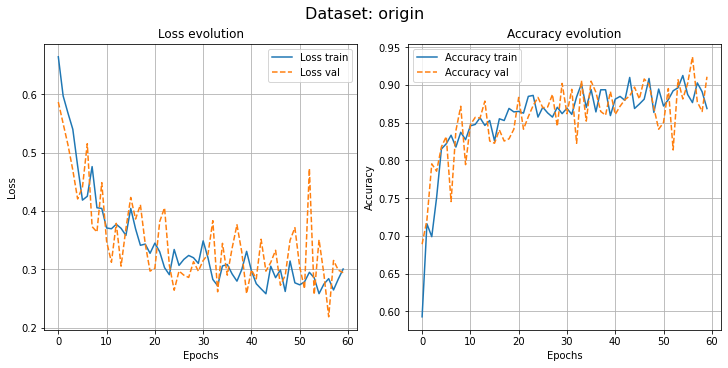

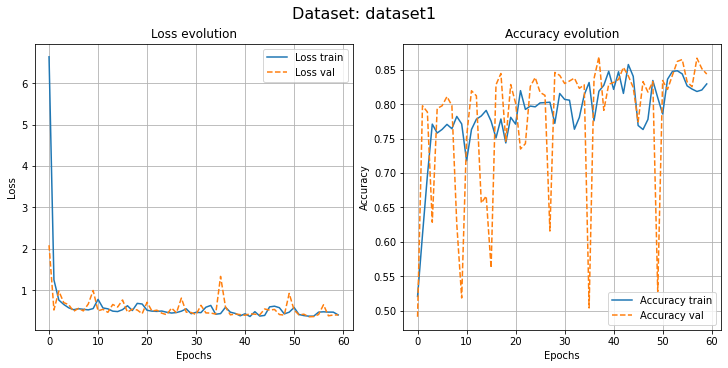

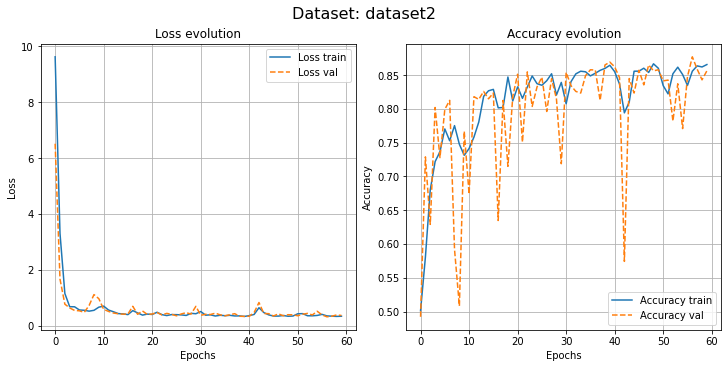

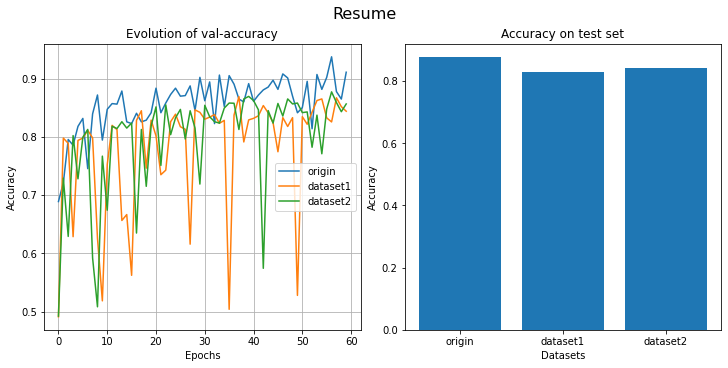

In [10]:
plot_hist(models)
    
